In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=f66c80f53cbcc0f56a272a760e469ac08d2c560303071f28a51cc6b97573dffa
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2 
from tqdm import tqdm
from torchvision import models
from efficientnet_pytorch import EfficientNet
from sklearn import metrics

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train = pd.read_csv('/content/train.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')
train[:int(train.shape[0]*0.85)]

,id,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,1
...,...,...
15820,15820.jpg,1
15821,15821.jpg,0
15822,15822.jpg,0
15823,15823.jpg,0


In [ ]:
class Dataset(Dataset):
    def __init__(self, root_images, root_file, mode, transform = None):
        self.root_images = root_images
        self.root_file = root_file
        self.transform = transform
        if mode == 'train' : self.file = pd.read_csv(root_file)[:int(pd.read_csv(root_file).shape[0]*0.85)].reset_index(drop=True)
        if mode == 'valid' : self.file = pd.read_csv(root_file)[int(pd.read_csv(root_file).shape[0]*0.85):].reset_index(drop=True)

    def __len__(self):
        return self.file.shape[0]
    
    def __getitem__(self,index):
        img_path = os.path.join(self.root_images, self.file['id'][index])
        image = np.array(Image.open(img_path).convert('RGB'))
        label = self.file['label'][index]
    
        if self.transform is not None:
            augmentations = self.transform(image = image)
            image = augmentations['image'] 
        
        return image, torch.tensor(label)

In [ ]:
learning_rate = 0.0001
batch_size = 32
epochs = 10
height = 224 
width = 224
IMG = '/content/drive/MyDrive/Colab Notebooks/AI images or Not/test'
FILE = '/content/train.csv'

In [ ]:
def get_loader(image, file, batch_size, train_transform, val_transform):
    
    train_ds = Dataset(image , file, 'train', train_transform)
    train_loader = DataLoader(train_ds, batch_size= batch_size, shuffle= True)

    val_ds = Dataset(image , file, 'valid', val_transform)
    val_loader = DataLoader(val_ds, batch_size= batch_size, shuffle= False)


    return train_loader , val_loader

In [ ]:
normalize = A.Normalize(
    mean = [0.485 , 0.456 , 0.406],
    std = [0.229 , 0.224, 0.255],
    max_pixel_value= 255.0
)

def aug():
    train_transform = A.Compose(
        [A.Resize(width=width , height= height),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.15),
        A.Rotate(limit = 25),
        normalize,
        ToTensorV2()
        ]
    )

    val_transform = A.Compose(
        [A.Resize(width=width , height= height),
        normalize,
        ToTensorV2()
        ]
    )

    return train_transform , val_transform

train_transform , val_transform = aug()

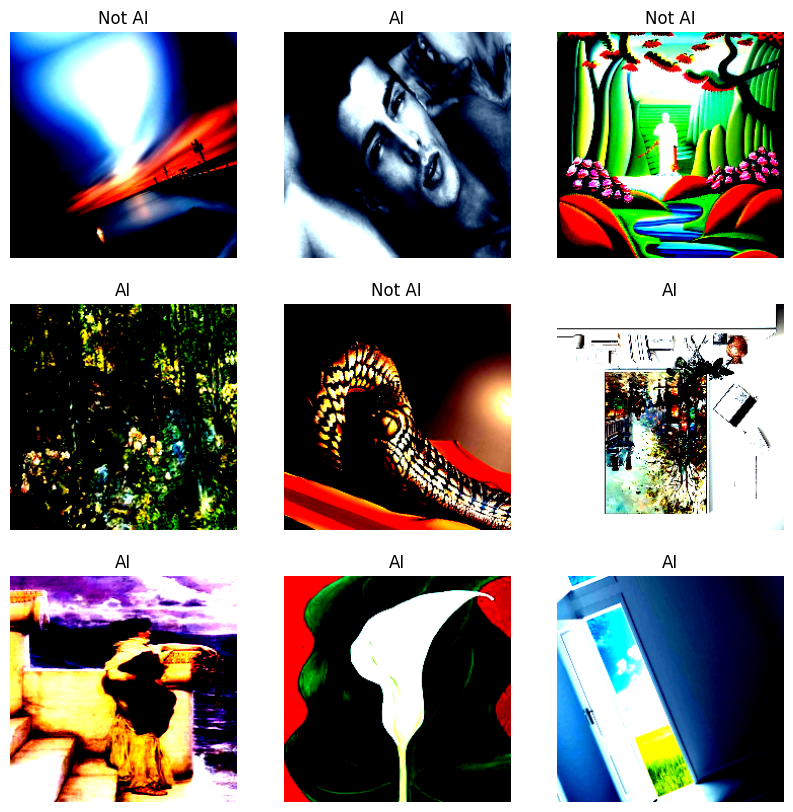

In [ ]:
def check_loader():
    train_loader, _ = get_loader(IMG, FILE, batch_size, train_transform, val_transform)
    image, label = next(iter(train_loader))
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].permute(1,2,0))
        plt.axis('off')
        name = ['AI', 'Not AI'][label[i].item()]
        ax.set_title(name)
        
check_loader()

#Note if images unclear, take out normalize from before, for better img quality 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        self.fct = nn.Linear(1000,1)
    
    def forward(self,img):
        x = self.model(img)
        # print(x.shape)
        x = self.fct(x)
        return x


# x = torch.randn(4,3,224,224)
# m = Net()
# m(x)

In [ ]:
def check_acc(loader, model, loss_fct):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device).to(torch.float32)
            y = y.to(device).to(torch.float32).unsqueeze(1)

            p = torch.sigmoid(model(x))
            preds = (p>0.7).float()

            num_correct += (preds==y).sum() 
            num_samples += preds.shape[0]
        
        print(f'Result: {num_correct}/{num_samples} with accuracy of {float(num_correct/num_samples) * 100:2f}')
    model.train()

def save_checkpoint(state, filename):
    print('====> saving...')
    torch.save(state, filename)


In [ ]:
def train_fct(loader, model, optimizer, loss_fct):
    for x,y in tqdm(loader):
        x = x.to(device).to(torch.float32)
        y = y.to(device).to(torch.float32).unsqueeze(1)

        scores = model(x)
        loss = loss_fct(scores, y)

        model.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
loss_fct = nn.BCEWithLogitsLoss().to(device)
model = Net().to(device)
optim = optim.Adam(model.parameters(), lr= learning_rate)
train_loader, val_loader = get_loader(IMG, FILE, batch_size, train_transform, val_transform)

check_acc(val_loader, model, loss_fct)

for epoch in range(epochs):
    train_fct(train_loader, model, optim, loss_fct)
    check_acc(val_loader, model, loss_fct)

    checkpoint = {
        'state_dict' : model.state_dict(),
        'optimizer'  : optim.state_dict()
    }

    save_checkpoint(checkpoint, '/content/Checkpoints/baseline_V0.pth.tar')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:01<00:00, 50.3MB/s]


Loaded pretrained weights for efficientnet-b4


100%|██████████| 88/88 [21:31<00:00, 14.68s/it]


Result: 1320/2793 with accuracy of 47.261009


100%|██████████| 88/88 [00:25<00:00,  3.49it/s]


Result: 2648/2793 with accuracy of 94.808447
====> saving...


100%|██████████| 88/88 [00:25<00:00,  3.48it/s]


Result: 2654/2793 with accuracy of 95.023268
====> saving...


100%|██████████| 88/88 [00:24<00:00,  3.64it/s]


Result: 2685/2793 with accuracy of 96.133184
====> saving...


100%|██████████| 88/88 [00:24<00:00,  3.58it/s]


Result: 2696/2793 with accuracy of 96.527028
====> saving...


100%|██████████| 88/88 [00:23<00:00,  3.67it/s]


Result: 2674/2793 with accuracy of 95.739347
====> saving...


100%|██████████| 88/88 [00:24<00:00,  3.59it/s]


Result: 2674/2793 with accuracy of 95.739347
====> saving...


100%|██████████| 88/88 [00:25<00:00,  3.52it/s]


Result: 2702/2793 with accuracy of 96.741849
====> saving...


100%|██████████| 88/88 [00:24<00:00,  3.56it/s]


Result: 2688/2793 with accuracy of 96.240598
====> saving...


100%|██████████| 88/88 [00:24<00:00,  3.57it/s]


Result: 2695/2793 with accuracy of 96.491224
====> saving...


100%|██████████| 88/88 [00:24<00:00,  3.56it/s]


Result: 2697/2793 with accuracy of 96.562833
====> saving...
